In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Generating Data:

I intentionally generate data that is hard to separate 

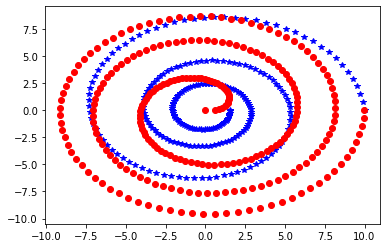

In [2]:
m=502
t=np.linspace(0,6*np.pi,int(m/2))
x_t = 10*np.exp(-0.1*t)*np.cos(t)
y_t= 10*np.exp(-0.1*t)*np.sin(t)

x1_t = 10*np.sqrt(0.053*t)*np.cos(t)
y1_t = 10*np.sqrt(0.053*t)*np.sin(t)

#Plot

plt.plot(x_t,y_t,"b*")
plt.plot(x1_t,y1_t,"ro")
plt.show()

### Making the data readble for a Neural Network

Before feeding our data to our Neural Network we need to do some changes so we can work with the data

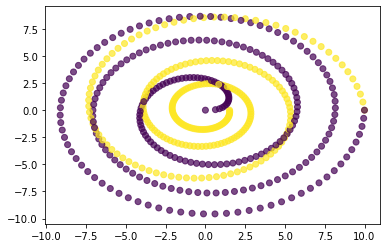

In [3]:
## Creating a label for data
c=np.ones((t.shape[0],1))
c=np.concatenate((c,np.zeros((t.shape[0],1))))
c=c.T
y=c

## Createing a X matrix 
X1=np.concatenate((x_t,x1_t))
X2=np.concatenate((y_t,y1_t))
X= np.array([X1,X2])

#Shuffle Data
permutation = list(np.random.permutation(m))
X = X[:, permutation]
y = y[:, permutation].reshape((1,m))

#Plot (just to verify we did it correctly)
plt.scatter(X[0,:],X[1,:], c=y ,alpha=0.7,)
plt.show()

### Lets meet our data ;)

In [4]:
m_train = round(m*0.75)
m_test = m-m_train

X_train=X[:,0:m_train]
y_train=y[:,0:m_train ]
X_test=X[:,m_train :m]
y_test=y[:,m_train :m]

print("SUMMARY OF DATA SET: \n")
print('size of examples:', m)
print("size of trainning data: ",m_train)
print("size of test data: ",m_test,"\n")

print("X_train:",X_train.shape,"y_train",y_train.shape)
print("X_test:",X_test.shape,"y_test",y_test.shape)

SUMMARY OF DATA SET: 

size of examples: 502
size of trainning data:  376
size of test data:  126 

X_train: (2, 376) y_train (1, 376)
X_test: (2, 126) y_test (1, 126)


### ACTIVATION FUNCTIONS AND DERIVATIVES

In [5]:
#Activation Functions:
def Sigmoid(Z):
    s = 1/(1+np.exp(-Z))
    return s

def Tanh(Z):
    t = np.tanh(Z)
    return t

def ReLU(Z):
    return Z * (Z > 0)

# Derivatives of Activation Functions:

def dSigmoid(A):
    return A*(1-A)

def dTanh(A):
    return 1-Tanh(A)**2

def dReLU(Z):
    return 1. * (Z > 0)

### Neural Network Architecture

In [15]:
Hidden_unit_size = 150
layers_dims = [X.shape[0],Hidden_unit_size,Hidden_unit_size,Hidden_unit_size,1] # 3 layer neuron (2 hidden layers)
#Activations=["ReLU","ReLU","ReLU","RelU","Sigmoid"]

m = y_train.shape[1]
parameters={}
for i in range(1,len(layers_dims)):
    parameters['W' + str(i)]=np.random.randn(layers_dims[i],layers_dims[i-1])*0.01
    parameters['b' + str(i)]=np.zeros((layers_dims[i],1))

### ALGORITHM

In order to have the best algorithm, we need to find the best Hyperparameters, for this we are going to implement I method I developed, which I named: Hidden Error Curve, to see how it works go to appendix

In [16]:
costs = []

learning_rates=[0.9,0.5,0.01,0.001]
learning_rate = learning_rates[0]

for iteration in range(0,3000):
    if iteration > 700:
        learning_rate = learning_rates[1]
    if iteration > 1500:
        learning_rate = learning_rates[2]
    if iteration > 1750:
        learning_rate = learning_rates[3]
        
    #Activation Topology:

    Activations=["ReLU","ReLU","ReLU","Sigmoid"]

    ##feedforward wit for: 

    forward = {}
    forward["A" + str(0)] =X_train

    for i in range(1,len(layers_dims)):
        forward["Z" + str(i)] =  parameters["W"+ str(i)].dot(forward["A" + str(i-1)])  + parameters["b"+ str(i)]
        if Activations[i-1] =="ReLU":
            forward["A" + str(i)] = ReLU(forward["Z" + str(i)])
        elif Activations[i-1] == "Sigmoid":
            forward["A" + str(i)] = Sigmoid(forward["Z" + str(i)])

    ###Cost


    logprobs =  y_train* np.log(forward["A" + str(i)]) + (1-y_train) * np.log(1- forward["A" + str(i)])
    cost = (-1/m)* np.sum(logprobs)
    costs.append(cost)


    ####Back Prop

    gradiants = {}
    gradiants["dA" +str(i)] = - (np.divide(y_train, forward["A" + str(i)]) - np.divide(1 - y_train, 1 - forward["A" + str(i)]))
    gradiants["dZ" +str(i)] = gradiants["dA" +str(i)]*dSigmoid(forward["A" + str(i)])

    for i in range(len(layers_dims)-1,0,-1): 
        gradiants['W' + str(i)]=1 / m *gradiants["dZ" +str(i)].dot(forward["A" + str(i-1)].T)
        gradiants['b' + str(i)]=1 / m * np.sum(gradiants["dZ" +str(i)], axis=1, keepdims=True)

        if i > 1: #  There is no need to calculate  dA0 and dZ0 (since A0 = inpunt and Z0 does not exist)

            gradiants["dA" +str(i-1)] = parameters["W"+ str(i)].T.dot(gradiants["dZ" +str(i)])
            gradiants["dZ" +str(i-1)] = gradiants["dA" +str(i-1)] * dReLU(forward["Z" + str(i-1)])


    for i in range(len(layers_dims)-1,0,-1): 
        parameters['W' + str(i)]=parameters['W' + str(i)] - learning_rate*gradiants['W' + str(i)]
        parameters['b' + str(i)]=parameters['b' + str(i)] - learning_rate*gradiants['b' + str(i)]
        

# Meassuring performance

prediction_train=(forward["A" + str(len(layers_dims)-1)] >= 0.5).astype(int)
accuracy_train=(prediction_train==y_train).astype(int).sum()/m*100
mt=X_test.shape[1]
        
forward = {}
forward["A" + str(0)] =X_test

for i in range(1,len(layers_dims)):
    forward["Z" + str(i)] =  parameters["W"+ str(i)].dot(forward["A" + str(i-1)])  + parameters["b"+ str(i)]
    if Activations[i-1] =="ReLU":
        forward["A" + str(i)] = ReLU(forward["Z" + str(i)])
    elif Activations[i-1] == "Sigmoid":
        forward["A" + str(i)] = Sigmoid(forward["Z" + str(i)])
        
prediction_test=(forward["A" + str(len(layers_dims)-1)] >= 0.5).astype(int)
accuracy_test=(prediction_test==y_test ).astype(int).sum()/mt*100

print("Accuracy on Train data:",accuracy_train,"%\nAccuaracy on Test data:",accuracy_test,"%")

Accuracy on Train data: 82.97872340425532 %
Accuaracy on Test data: 87.3015873015873 %


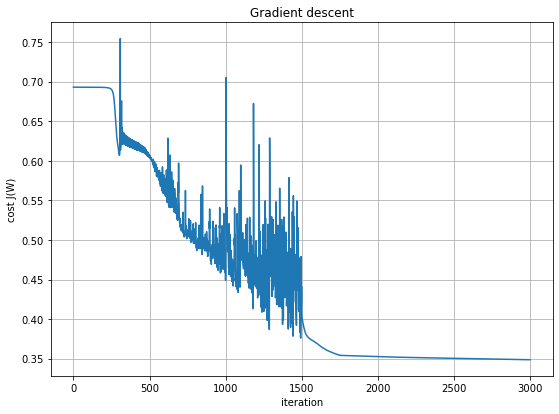

In [17]:
plt.plot(costs)
plt.title("Gradient descent")
plt.xlabel("iteration")
plt.ylabel("cost J(W)")
plt.grid()
plt.show()

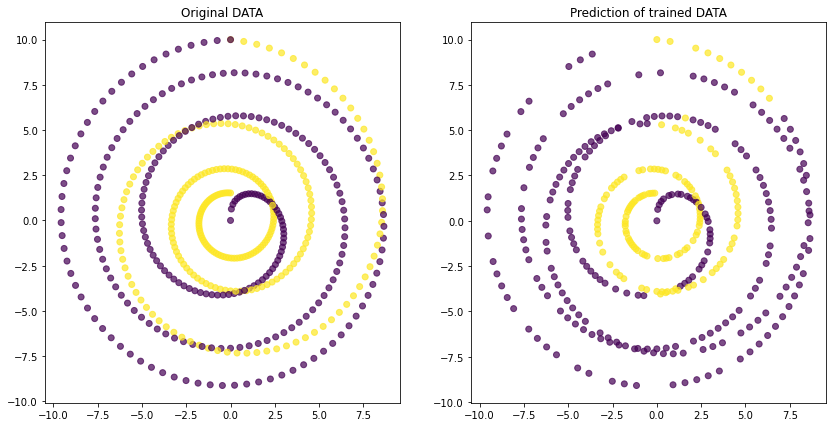

In [18]:
plt.rcParams['figure.figsize'] = [14,7]
fig = plt.figure()

ax1 = fig.add_subplot(121)
ax1.set_title("Original DATA")
ax1.scatter(X[1,:],X[0,:], c=y ,alpha=0.7,)


ax2 = fig.add_subplot(122)
ax2.set_title("Prediction of trained DATA")
ax2.scatter(X_train[1,:],X_train[0,:], c=prediction_train ,alpha=0.7,)
plt.show()

In [10]:
def Neural_network(layers_dims,Activations):
    #layers_dims = [X.shape[0],40,40,1] # 3 layer neuron (2 hidden layers)
    m = y_train.shape[1]
    parameters={}
    for i in range(1,len(layers_dims)):
        parameters['W' + str(i)]=np.random.randn(layers_dims[i],layers_dims[i-1])*0.01
        parameters['b' + str(i)]=np.zeros((layers_dims[i],1))

    costs = []

    learning_rates=[0.9,0.5,0.01,0.001]
    learning_rate = learning_rates[0]

    for iteration in range(0,2000):
        if iteration > 700:
            learning_rate = learning_rates[1]
        if iteration > 1500:
            learning_rate = learning_rates[2]
        if iteration > 1750:
            learning_rate = learning_rates[3]

        #Activation Topology:

       # Activations=["ReLU","ReLU","Sigmoid"]

        ##feedforward wit for: 

        forward = {}
        forward["A" + str(0)] =X_train

        for i in range(1,len(layers_dims)):
            forward["Z" + str(i)] =  parameters["W"+ str(i)].dot(forward["A" + str(i-1)])  + parameters["b"+ str(i)]
            if Activations[i-1] =="ReLU":
                forward["A" + str(i)] = ReLU(forward["Z" + str(i)])
            elif Activations[i-1] == "Sigmoid":
                forward["A" + str(i)] = Sigmoid(forward["Z" + str(i)])

        ###Cost


        logprobs =  y_train* np.log(forward["A" + str(i)]) + (1-y_train) * np.log(1- forward["A" + str(i)])
        cost = (-1/m)* np.sum(logprobs)
        costs.append(cost)


        ####Back Prop

        gradiants = {}
        gradiants["dA" +str(i)] = - (np.divide(y_train, forward["A" + str(i)]) - np.divide(1 - y_train, 1 - forward["A" + str(i)]))
        gradiants["dZ" +str(i)] = gradiants["dA" +str(i)]*dSigmoid(forward["A" + str(i)])

        for i in range(len(layers_dims)-1,0,-1): 
            gradiants['W' + str(i)]=1 / m *gradiants["dZ" +str(i)].dot(forward["A" + str(i-1)].T)
            gradiants['b' + str(i)]=1 / m * np.sum(gradiants["dZ" +str(i)], axis=1, keepdims=True)

            if i > 1: #  There is no need to calculate  dA0 and dZ0 (since A0 = inpunt and Z0 does not exist)

                gradiants["dA" +str(i-1)] = parameters["W"+ str(i)].T.dot(gradiants["dZ" +str(i)])
                gradiants["dZ" +str(i-1)] = gradiants["dA" +str(i-1)] * dReLU(forward["Z" + str(i-1)])


        for i in range(len(layers_dims)-1,0,-1): 
            parameters['W' + str(i)]=parameters['W' + str(i)] - learning_rate*gradiants['W' + str(i)]
            parameters['b' + str(i)]=parameters['b' + str(i)] - learning_rate*gradiants['b' + str(i)]



    prediction_train=(forward["A" + str(len(layers_dims)-1)] >= 0.5).astype(int)
    accuracy_train=(prediction_train==y_train).astype(int).sum()/m*100
    mt=X_test.shape[1]

    forward = {}
    forward["A" + str(0)] =X_test

    for i in range(1,len(layers_dims)):
        forward["Z" + str(i)] =  parameters["W"+ str(i)].dot(forward["A" + str(i-1)])  + parameters["b"+ str(i)]
        if Activations[i-1] =="ReLU":
            forward["A" + str(i)] = ReLU(forward["Z" + str(i)])
        elif Activations[i-1] == "Sigmoid":
            forward["A" + str(i)] = Sigmoid(forward["Z" + str(i)])

    prediction_test=(forward["A" + str(len(layers_dims)-1)] >= 0.5).astype(int)
    accuracy_test=(prediction_test==y_test ).astype(int).sum()/mt*100

    #print("Accuracy on Train data:",accuracy_train,"%\nAccuaracy on Test data:",accuracy_test,"%")
    
    return (accuracy_train,accuracy_test)

# appendix

###  Hyper Parameters Tunning:      Hidden Error curves

In [11]:
plt.rcParams['figure.figsize'] = [9,6.5]

                           Hidden Units 40
1 Hidden layer
Accuracy on Train data: 62.5 %
Accuaracy on Test data: 70.63492063492063 %
2 Hidden layers
Accuracy on Train data: 65.95744680851064 %
Accuaracy on Test data: 68.25396825396825 %
3 Hidden layers
Accuracy on Train data: 50.26595744680851 %
Accuaracy on Test data: 49.2063492063492 %
4 Hidden layers
Accuracy on Train data: 50.26595744680851 %
Accuaracy on Test data: 49.2063492063492 %


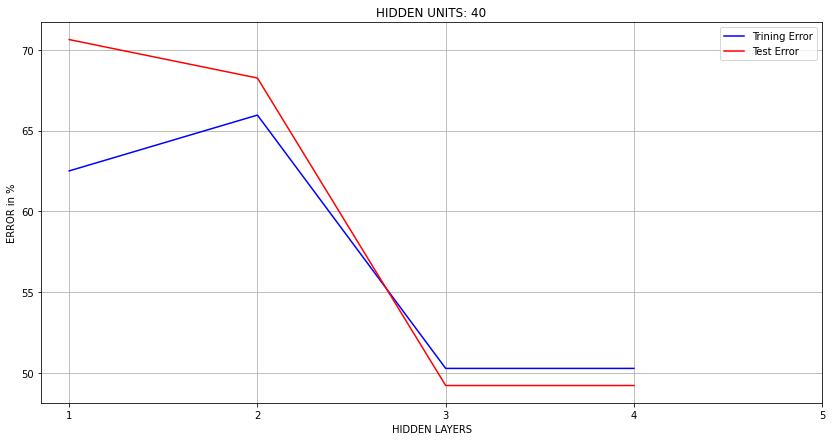

                           Hidden Units 100
1 Hidden layer
Accuracy on Train data: 59.840425531914896 %
Accuaracy on Test data: 70.63492063492063 %
2 Hidden layers
Accuracy on Train data: 76.59574468085107 %
Accuaracy on Test data: 75.39682539682539 %
3 Hidden layers
Accuracy on Train data: 76.86170212765957 %
Accuaracy on Test data: 82.53968253968253 %
4 Hidden layers
Accuracy on Train data: 50.26595744680851 %
Accuaracy on Test data: 49.2063492063492 %


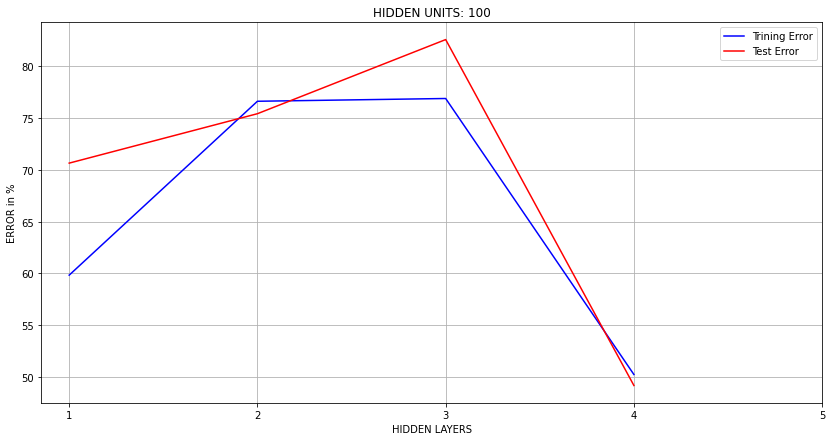

                           Hidden Units 150
1 Hidden layer
Accuracy on Train data: 60.1063829787234 %
Accuaracy on Test data: 69.84126984126983 %
2 Hidden layers
Accuracy on Train data: 70.74468085106383 %
Accuaracy on Test data: 76.19047619047619 %
3 Hidden layers
Accuracy on Train data: 88.82978723404256 %
Accuaracy on Test data: 89.68253968253968 %
4 Hidden layers
Accuracy on Train data: 50.26595744680851 %
Accuaracy on Test data: 49.2063492063492 %


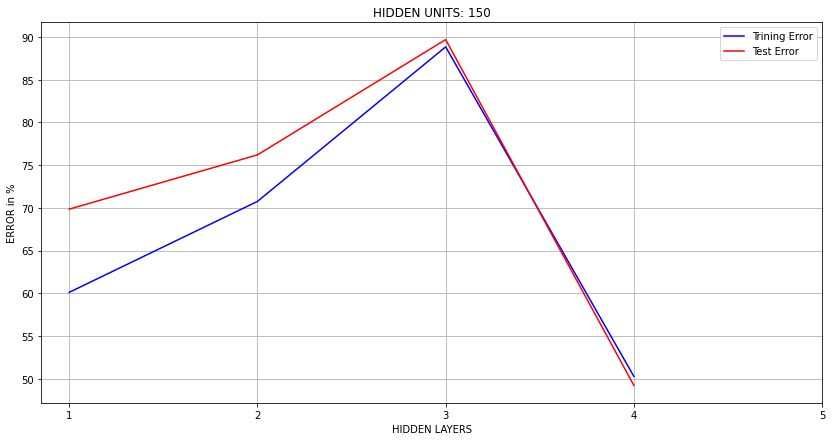

                           Hidden Units 200
1 Hidden layer
Accuracy on Train data: 60.1063829787234 %
Accuaracy on Test data: 69.04761904761905 %
2 Hidden layers
Accuracy on Train data: 84.57446808510637 %
Accuaracy on Test data: 81.74603174603175 %
3 Hidden layers
Accuracy on Train data: 79.52127659574468 %
Accuaracy on Test data: 78.57142857142857 %
4 Hidden layers
Accuracy on Train data: 66.22340425531915 %
Accuaracy on Test data: 76.19047619047619 %


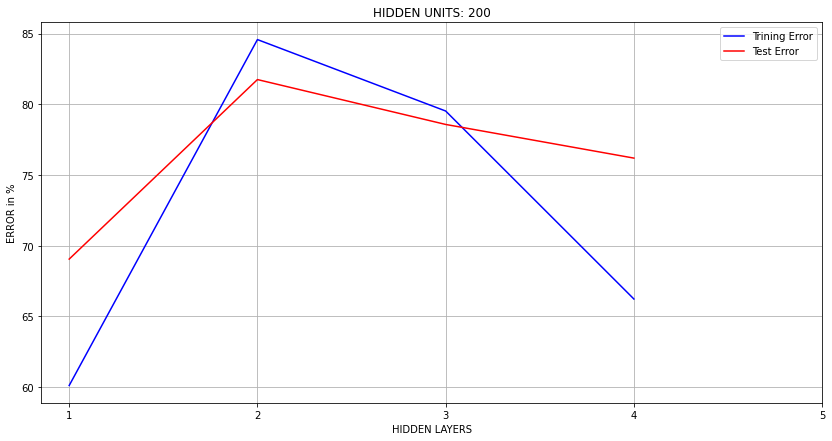

SUMMARY


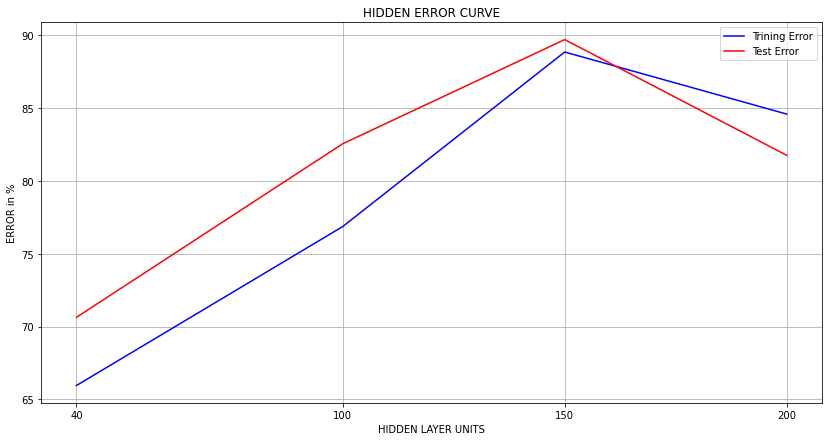

Best train error in: 150 hidden units with 3 Layers   Error: 88.82978723404256 % 
Best test error  in: 150 hidden units with 3 Layers   Error: 89.68253968253968 % 


In [19]:
max_hidden_layer_training_list=[]
max_hidden_layer_test_list=[]

max_training_list=[]
max_testing_list =[]

Hidden_unit_sizes = [40,100,150,200]
for Hidden_unit_size in Hidden_unit_sizes:

    training_list=[]
    testing_list =[]
    print('\033[1m' + "                           Hidden Units", Hidden_unit_size)

    print('\033[1m' + "1 Hidden layer")
    layers_dims = [X.shape[0],Hidden_unit_size,1]
    Activations=["ReLU","Sigmoid"]
    Answers = Neural_network(layers_dims,Activations)
    tr =Answers[0]
    te =Answers[1]
    print('\033[0m' + "Accuracy on Train data:",tr ,"%\nAccuaracy on Test data:",te,"%")
    training_list.append(tr)
    testing_list.append(te)

    #print("\n")

    print('\033[1m' + "2 Hidden layers")
    layers_dims = [X.shape[0],Hidden_unit_size,Hidden_unit_size,1]
    Activations=["ReLU","ReLU","Sigmoid"]
    Answers = Neural_network(layers_dims,Activations)
    tr =Answers[0]
    te =Answers[1]
    print('\033[0m' + "Accuracy on Train data:",tr ,"%\nAccuaracy on Test data:",te,"%")
    training_list.append(tr)
    testing_list.append(te)
    #print("\n")

    print('\033[1m' + "3 Hidden layers")
    layers_dims = [X.shape[0],Hidden_unit_size,Hidden_unit_size,Hidden_unit_size,1]
    Activations=["ReLU","ReLU","ReLU","Sigmoid"]
    Answers = Neural_network(layers_dims,Activations)
    tr =Answers[0]
    te =Answers[1]
    print('\033[0m' + "Accuracy on Train data:",tr ,"%\nAccuaracy on Test data:",te,"%")
    training_list.append(tr)
    testing_list.append(te)
    #print("\n")

    print('\033[1m' + "4 Hidden layers")
    layers_dims = [X.shape[0],Hidden_unit_size,Hidden_unit_size,Hidden_unit_size,Hidden_unit_size,1]
    Activations=["ReLU","ReLU","ReLU","ReLU","Sigmoid"]
    Answers = Neural_network(layers_dims,Activations)
    tr =Answers[0]
    te =Answers[1]
    print('\033[0m' + "Accuracy on Train data:",tr ,"%\nAccuaracy on Test data:",te,"%")
    training_list.append(tr)
    testing_list.append(te)
    #print("\n")
    
    max_training_list.append(np.max(training_list))
    max_testing_list.append(np.max(testing_list))
    
    max_hidden_layer_training_list.append(np.argmax(training_list)+1)
    max_hidden_layer_test_list.append(np.argmax(testing_list)+1)
    
    


    plt.title("HIDDEN UNITS: {}".format(Hidden_unit_size))
    plt.plot(np.array([1,2,3,4]),np.array(training_list),"b",label="Trining Error")
    plt.plot(np.array([1,2,3,4]),np.array(testing_list),"r",label="Test Error")
    plt.legend()
    plt.xlabel("HIDDEN LAYERS")
    plt.ylabel("ERROR in %")
    plt.grid()
    plt.xticks(ticks=np.array([1,2,3,4,5]))
    plt.show()

print('\033[1m' + "SUMMARY")
plt.title("HIDDEN ERROR CURVE")
plt.plot(np.array(Hidden_unit_sizes),np.array(max_training_list),"b",label="Trining Error")
plt.plot(np.array(Hidden_unit_sizes),np.array(max_testing_list ),"r",label="Test Error")
plt.legend()
plt.xlabel("HIDDEN LAYER UNITS")
plt.ylabel("ERROR in %")
plt.grid()
plt.xticks(ticks=np.array(Hidden_unit_sizes))
plt.show()

print('\033[1m' +  "Best train error in:", Hidden_unit_sizes[np.argmax(max_training_list)],"hidden units with",max_hidden_layer_training_list[np.argmax(max_training_list)],"Layers","  Error:",max(max_training_list),"% ")
print('\033[1m' +  "Best test error  in:", Hidden_unit_sizes[np.argmax(max_testing_list)],"hidden units with",max_hidden_layer_test_list[np.argmax(max_testing_list)],"Layers","  Error:",max(max_testing_list),"% ")

DESCRIPTION: a Hidden Error curve plot is basically the argmax(error_list_given_l_layers) of both training and test errors. On the Y-axis we see the error, while on the X-axis we see the number of hidden units of the Neural architecture that performed the best

For more information on Hidden Error Curves Contact me: elozanog1600@alumno.ipn.mx